In [113]:
import numpy as np 
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
    
from sklearn.svm import SVC 

# Train/Test Preparation

In [423]:
# Scraped yahoo data
options_data_3_18_df = pd.read_csv('yahooData/results/finalData_18.csv', delimiter=',')

# add a new column for the difference of the date to expiration date
options_data_3_18_df['Record Time'] = pd.to_datetime(options_data_3_18_df['Record Time'])
options_data_3_18_df['Expiration Date'] = pd.to_datetime(options_data_3_18_df['Expiration Date'])
options_data_3_18_df['DaysToExpiration'] = options_data_3_18_df['Expiration Date'] - options_data_3_18_df['Record Time']
options_data_3_18_df['DaysToExpiration'] = options_data_3_18_df['DaysToExpiration'].dt.days + 1

# Let's take a look at amzn calls and puts
amzn_options_data_3_18_df = options_data_3_18_df[options_data_3_18_df.Symbol=='AMZN']
# amzn_options_data_3_18_df = amzn_options_data_3_18_df[amzn_options_data_3_18_df.Call==True]
amzn_options_data_3_18_df = amzn_options_data_3_18_df.drop(columns=['Symbol','Expiration Date', 'Sector', 'Industry', 'Record Time', 'Profit', 'Current Price', 'Call', 
                                                                    'In the Money', 'DaysToExpiration'])
# amzn_options_data_3_18_df = amzn_options_data_3_18_df.replace({'In the Money': {'True':1,'False':0}})
# amzn_options_data_3_18_df = amzn_options_data_3_18_df.replace({'Call': {True:1,False:0}})
amzn_options_data_3_18_df

,Strike,Implied Volatility,Mark,Success
279,1400.0,2.266667,1362.750,1
280,1500.0,2.443272,1276.100,1
281,1520.0,1.964539,1241.225,1
282,1540.0,4.417332,1388.200,1
283,1560.0,2.245610,1213.350,1
...,...,...,...,...
208426,5100.0,4.253423,1872.500,0
208427,5200.0,9.376469,2147.800,0
208428,5300.0,8.001653,2173.475,0
208429,5400.0,4.681645,2172.500,0


In [424]:
# "Success" col is actually " Success"
X = amzn_options_data_3_18_df[amzn_options_data_3_18_df.columns.difference([' Success'], sort=False)]
y = amzn_options_data_3_18_df[amzn_options_data_3_18_df.columns[-1]] # " Success" column
y

279       1
280       1
281       1
282       1
283       1
         ..
208426    0
208427    0
208428    0
208429    0
208430    0
Name:  Success, Length: 10590, dtype: int64

In [425]:
# feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
print(X_train, y_train)

[[ 0.62977211 -0.37585241 -0.63472586]
 [ 0.58097694  0.41027739 -0.01789047]
 [ 0.19061562 -0.45826189 -0.61248694]
 ...
 [ 0.01373314 -0.48025137 -0.48858726]
 [ 1.45928993 -0.72572229  0.84244489]
 [ 2.13022345 -0.72572229  2.91067501]] 20596     0
183165    0
146664    1
613       1
31716     1
         ..
118248    1
107157    0
107356    1
12020     0
147047    0
Name:  Success, Length: 8472, dtype: int64


# Logistic Regression

In [426]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
log_reg_model.score(X_test, y_test)

0.9910292728989613

**classification --> will our option be profitable-- yes or no?** \
seems pretty high...but our options are also priced 9 days out for now, so maybe thats why?

with just: Strike  Current Price  Implied Volatility  Call   Success  DaysToExpiration  
- acc: 0.9480642115203022
- adding in the mark boosts this to: 0.9905571293673276
- adding "in the money" decreases to: 0.9768649669499528
    
with just: Strike  Current Price  In the Money  Call   Success  DaysToExpiration
- acc: 0.8319169027384324
- from there add 'Implied Volatility': 0.9768649669499528
    
log_reg_model.coef_
- array([[-17.8157179 ,  -0.43907748,  -3.35907594,  -0.53774606, 0.05101503,  -7.44636698,  -0.42466597]])
- what is important: strike, implied volatility, mark

strike, implied volatility, mark
0.9910292728989613

strike, implied volatility
0.9362606232294618

implied volatility, mark
0.6350330500472143

strike, mark
1.0

ONLY implied volatility 
0.6180358829084042

ONLY mark
0.6274787535410765

ONLY strike
0.8550519357884797

# Support Vector Machine (SVM)

In [427]:
SVM_model = SVC(gamma='auto')
SVM_model.fit(X_train, y_train)
SVM_model.score(X_test, y_test)

0.9943342776203966

with just: Strike  Current Price  Implied Volatility  Call   Success  DaysToExpiration  
- acc: 0.9853635505193579
- adding in the mark boosts this to: 0.9891406987724268
- adding "in the money" decreases to: 0.9858356940509915
    
with just: Strike  Current Price  In the Money  Call   Success  DaysToExpiration
- acc: 0.8937677053824362
- from there add 'Implied Volatility': 0.9858356940509915

strike, implied volatility, mark
0.9943342776203966

strike, implied volatility
0.9551463644948064

implied volatility, mark
0.7214353163361662

strike, mark
0.9886685552407932

ONLY implied volatility
0.6558073654390935

ONLY mark
0.6968838526912181

ONLY strike
0.8654390934844193

# Conclusions?

- strike price alone does pretty well (this is the MOST important) --> duh
- strike + mark = basically 100% 
- strike + mark + implied volatility actually does a little worse than just strike + mark (sometimes)
  - generally, strike + mark + implied volatility seems to do pretty well
- doesnt matter if its a call or put --> no difference in performance (pretty interesting)

<AxesSubplot:>

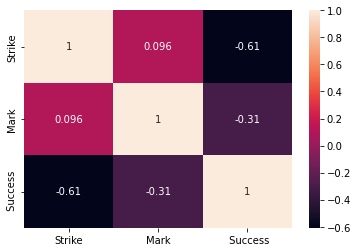

In [307]:
import seaborn as sns   
sns.heatmap(amzn_options_data_3_18_df.corr(),annot= True)